In [1]:
student_id = '20224258'
model_name = '20224258'

In [2]:
from competition_utils import *
from training_args import *

model_name = f'submission_{model_name}'
module_path = f"models.submission_{student_id}.{model_name}"
module = importlib.import_module(module_path)
globals()[model_name] = getattr(module, model_name)

Project_Name = 'Competition'
model_dir = 'models'
output_root = 'output'

SAVE_RESULT = True
SAVE_N = 1500
vis_root = f'vis/TEST_OUTPUTS_{datetime.now().strftime("%y%m%d_%H%M%S")}'

Dataset_root = 'Datasets'
Dataset_Name_list = [
                    #  'VOC',
                     'ETIS',
                     'CVPPP',
                     'CFD',
                     'CarDD',
]
number_of_classes_dict = {'VOC':21,
                          'ETIS':2,
                          'CVPPP':2,
                          'CFD':2,
                          'CarDD':2
                         }
epochs = 30
EARLY_STOP = 100
batch_size = 16
EXCLUDE_BACKGROUND = True
BINARY_SEG = None
THRESHOLD = 0.5
device = "cuda" if torch.cuda.is_available() else "cpu"

=== Learning Rate 변화 분석 시작 ===
📊 Learning Rate 변화 계산 중...
✅ 30 epoch 동안의 Learning Rate 변화 계산 완료


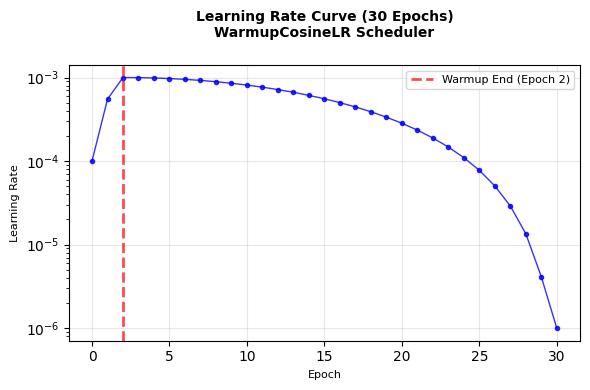


✅ Learning Rate 분석 완료!


In [3]:
# ==================== Learning Rate 변화 추적 및 시각화 ====================
import matplotlib.pyplot as plt
import numpy as np
import torch

print("=== Learning Rate 변화 분석 시작 ===")

# 더미 모델과 옵티마이저 생성 (실제 학습 설정과 동일하게)
print("📊 Learning Rate 변화 계산 중...")

class DummyModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layer = torch.nn.Linear(1, 1)
    def parameters(self):
        return [torch.nn.Parameter(torch.zeros(1))]

dummy_model = DummyModel()
optimizer = Make_Optimizer(dummy_model)
lr_scheduler = Make_LR_Scheduler(optimizer)

# 30 epoch 동안의 learning rate 변화 기록
epochs_list = []
lr_values = []

# 초기 learning rate 기록
current_lr = optimizer.param_groups[0]['lr']
epochs_list.append(0)
lr_values.append(current_lr)

# 각 epoch마다 scheduler step 실행하며 learning rate 기록
for epoch in range(1, epochs + 1):
    lr_scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']
    epochs_list.append(epoch)
    lr_values.append(current_lr)

print(f"✅ {epochs} epoch 동안의 Learning Rate 변화 계산 완료")

# Learning Rate 변화 그래프 생성
plt.figure(figsize=(6, 4))
plt.plot(epochs_list, lr_values, 'b-', linewidth=1, marker='o', markersize=3, alpha=0.8)
plt.title(f'Learning Rate Curve (30 Epochs)\n{lr_scheduler.__class__.__name__} Scheduler', 
          fontsize=10, fontweight='bold', pad=20)
plt.xlabel('Epoch', fontsize=8)
plt.ylabel('Learning Rate', fontsize=8)
plt.grid(True, alpha=0.3)
plt.yscale('log')  # 로그 스케일로 표시

# Warmup 구간 표시 (있는 경우)
if hasattr(lr_scheduler, 'warmup_iters') and lr_scheduler.warmup_iters > 0:
    warmup_epochs = lr_scheduler.warmup_iters
    plt.axvline(x=warmup_epochs, color='red', linestyle='--', alpha=0.7, linewidth=2,
               label=f'Warmup End (Epoch {warmup_epochs})')
    plt.legend(fontsize=8)

plt.tight_layout()
plt.show()
plt.close()  # 메모리 절약을 위해 close

print(f"\n✅ Learning Rate 분석 완료!")


In [4]:
now = datetime.now()
Experiments_Time=now.strftime("%y%m%d_%H%M%S")
print('Experiment Start Time:',Experiments_Time)
eval_columns=['Experiment Time','Train Time', 'Dataset Name', 'Model Name', 'Val Loss', 'Test Loss', 'IoU', 'Dice',  'Precision', 'Recall', 'Total Params','Train-Predction Time']
df = pd.DataFrame(index=None, columns=eval_columns)
output_root = f'{output_root}/output_{Experiments_Time}'
os.makedirs(output_root, exist_ok = True)
seed = iteration = 1
for j, Dataset_Name in enumerate(Dataset_Name_list):
    print(f'Dataset: {Dataset_Name} ({j+1}/{len(Dataset_Name_list)})')
    control_random_seed(seed)
    Dataset_dir = Dataset_root+'/'+Dataset_Name
    Height, Width = (256, 256)
    in_channels = 3
    number_of_classes = number_of_classes_dict[Dataset_Name]
    BINARY_SEG = True if number_of_classes==2 else False
    exclude_background = EXCLUDE_BACKGROUND
    out_channels = 1 if BINARY_SEG else number_of_classes

    train_image_path_list = natsort.natsorted(glob.glob(f"{Dataset_dir}/train/Originals/*"))
    train_target_path_list = natsort.natsorted(glob.glob(f"{Dataset_dir}/train/Masks/*"))
    validation_image_path_list = natsort.natsorted(glob.glob(f"{Dataset_dir}/val/Originals/*"))
    validation_target_path_list = natsort.natsorted(glob.glob(f"{Dataset_dir}/val/Masks/*"))
    test_image_path_list = natsort.natsorted(glob.glob(f"{Dataset_dir}/test/Originals/*"))
    test_target_path_list = natsort.natsorted(glob.glob(f"{Dataset_dir}/test/Masks/*"))
    print(f'train/val/test: {len(train_image_path_list)}/{len(validation_image_path_list)}/{len(test_image_path_list)}')

    # train_dataset = ImagesDataset(train_image_path_list, train_target_path_list, augment=False)
    train_dataset = ImagesDataset(train_image_path_list, train_target_path_list)
    validation_dataset = ImagesDataset(validation_image_path_list, validation_target_path_list)
    test_dataset = ImagesDataset(test_image_path_list, test_target_path_list)
    train_loader = SegDataLoader(
    train_dataset, batch_size=batch_size,
    num_workers=4, pin_memory=True, shuffle=True, drop_last=True, fill_last_batch=False,
    )
    validation_loader = SegDataLoader(
        validation_dataset, batch_size=batch_size, 
        num_workers=4, pin_memory=True,
    )
    test_loader = SegDataLoader(
        test_dataset, batch_size=batch_size, 
        num_workers=4, pin_memory=True,
    )

    print(f'{model_name}', end=' ')
    print(f'Dataset: {Dataset_Name}) ({j+1}/{len(Dataset_Name_list)})', end=' ')
    output_dir = output_root + f'/{model_name}_{Dataset_Name}'
    control_random_seed(seed)
    model=globals()[model_name](in_channels, out_channels)
    model = model.to(device)
    optimizer = Make_Optimizer(model)
    lr_scheduler = Make_LR_Scheduler(optimizer)
    criterion = Make_Loss_Function(number_of_classes)
    if SAVE_RESULT==True:
        os.makedirs(vis_root+f"/{Dataset_Name}", exist_ok=True)
    df = Execute_Experiment(model_name, model, Dataset_Name, train_loader, validation_loader, test_loader, 
                            optimizer, lr_scheduler, criterion, number_of_classes, df, epochs, device, output_dir,
                           BINARY_SEG, exclude_background, out_channels, seed, THRESHOLD, EARLY_STOP, SAVE_RESULT, vis_root+f"/{Dataset_Name}", Experiments_Time
                           )
    df.to_csv(output_root+'/'+f'{Project_Name}_'+Experiments_Time+'.csv', index=False, header=True, encoding="cp949")

Experiment Start Time: 250616_231122
Dataset: ETIS (1/4)
train/val/test: 118/39/39
submission_20224258 Dataset: ETIS) (1/4) Training Start Time: 250616_231122


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

1EP(250616_231124): T_Loss: 0.952021 V_Loss: 0.957293 IoU: 0.0242 Best Epoch: 1 Loss: 0.957293


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

2EP(250616_231126): T_Loss: 0.934954 V_Loss: 0.940503 IoU: 0.0000 Best Epoch: 2 Loss: 0.940503


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

3EP(250616_231127): T_Loss: 0.913726 V_Loss: 0.893473 IoU: 0.0000 Best Epoch: 3 Loss: 0.893473


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

4EP(250616_231128): T_Loss: 0.892485 V_Loss: 0.856414 IoU: 0.0000 Best Epoch: 4 Loss: 0.856414


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

5EP(250616_231130): T_Loss: 0.875253 V_Loss: 0.841450 IoU: 0.0000 Best Epoch: 5 Loss: 0.841450


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

6EP(250616_231131): T_Loss: 0.861842 V_Loss: 0.836034 IoU: 0.0000 Best Epoch: 6 Loss: 0.836034


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

7EP(250616_231133): T_Loss: 0.849772 V_Loss: 0.830020 IoU: 0.0000 Best Epoch: 7 Loss: 0.830020


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

8EP(250616_231134): T_Loss: 0.838936 V_Loss: 0.828861 IoU: 0.0000 Best Epoch: 8 Loss: 0.828861


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

9EP(250616_231135): T_Loss: 0.829153 V_Loss: 0.832109 IoU: 0.0001 


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

10EP(250616_231137): T_Loss: 0.820734 V_Loss: 0.832669 IoU: 0.0001 


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

11EP(250616_231138): T_Loss: 0.813100 V_Loss: 0.818897 IoU: 0.0001 Best Epoch: 11 Loss: 0.818897


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

12EP(250616_231140): T_Loss: 0.805769 V_Loss: 0.811753 IoU: 0.0001 Best Epoch: 12 Loss: 0.811753


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

13EP(250616_231141): T_Loss: 0.799890 V_Loss: 0.802441 IoU: 0.0001 Best Epoch: 13 Loss: 0.802441


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

14EP(250616_231142): T_Loss: 0.794300 V_Loss: 0.798649 IoU: 0.0000 Best Epoch: 14 Loss: 0.798649


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

15EP(250616_231144): T_Loss: 0.789596 V_Loss: 0.792487 IoU: 0.0000 Best Epoch: 15 Loss: 0.792487


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

16EP(250616_231145): T_Loss: 0.785148 V_Loss: 0.788744 IoU: 0.0000 Best Epoch: 16 Loss: 0.788744


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

17EP(250616_231147): T_Loss: 0.781388 V_Loss: 0.783980 IoU: 0.0000 Best Epoch: 17 Loss: 0.783980


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

18EP(250616_231148): T_Loss: 0.778295 V_Loss: 0.780666 IoU: 0.0000 Best Epoch: 18 Loss: 0.780666


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

19EP(250616_231149): T_Loss: 0.775548 V_Loss: 0.778478 IoU: 0.0000 Best Epoch: 19 Loss: 0.778478


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

20EP(250616_231151): T_Loss: 0.773078 V_Loss: 0.774963 IoU: 0.0000 Best Epoch: 20 Loss: 0.774963


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

21EP(250616_231152): T_Loss: 0.771195 V_Loss: 0.773522 IoU: 0.0000 Best Epoch: 21 Loss: 0.773522


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

22EP(250616_231154): T_Loss: 0.769846 V_Loss: 0.771862 IoU: 0.0000 Best Epoch: 22 Loss: 0.771862


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

23EP(250616_231155): T_Loss: 0.768511 V_Loss: 0.770534 IoU: 0.0000 Best Epoch: 23 Loss: 0.770534


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

24EP(250616_231156): T_Loss: 0.767508 V_Loss: 0.768891 IoU: 0.0000 Best Epoch: 24 Loss: 0.768891


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

25EP(250616_231158): T_Loss: 0.766728 V_Loss: 0.768277 IoU: 0.0000 Best Epoch: 25 Loss: 0.768277


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

26EP(250616_231159): T_Loss: 0.766190 V_Loss: 0.767778 IoU: 0.0000 Best Epoch: 26 Loss: 0.767778


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

27EP(250616_231201): T_Loss: 0.766297 V_Loss: 0.767131 IoU: 0.0000 Best Epoch: 27 Loss: 0.767131


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

28EP(250616_231202): T_Loss: 0.765820 V_Loss: 0.766871 IoU: 0.0000 Best Epoch: 28 Loss: 0.766871


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

29EP(250616_231203): T_Loss: 0.765504 V_Loss: 0.766608 IoU: 0.0000 Best Epoch: 29 Loss: 0.766608


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

30EP(250616_231205): T_Loss: 0.765234 V_Loss: 0.766380 IoU: 0.0000 Best Epoch: 30 Loss: 0.766380
Test Start Time: 250616_231205


Test:   0%|          | 0/3 [00:00<?, ?batch/s]

Best Epoch: 30
Test(250616_231216): Loss: 0.764892 IoU: 0.0000 Dice: 0.0000 Precision: 0.0000 Recall: 0.0000
End 250616_231216
Dataset: CVPPP (2/4)
train/val/test: 486/162/162
submission_20224258 Dataset: CVPPP) (2/4) Training Start Time: 250616_231216


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

1EP(250616_231220): T_Loss: 0.864066 V_Loss: 0.852052 IoU: 0.4631 Best Epoch: 1 Loss: 0.852052


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

2EP(250616_231224): T_Loss: 0.804406 V_Loss: 0.816029 IoU: 0.4714 Best Epoch: 2 Loss: 0.816029


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

3EP(250616_231229): T_Loss: 0.769287 V_Loss: 0.743802 IoU: 0.8146 Best Epoch: 3 Loss: 0.743802


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

4EP(250616_231233): T_Loss: 0.736611 V_Loss: 0.722534 IoU: 0.8476 Best Epoch: 4 Loss: 0.722534


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

5EP(250616_231237): T_Loss: 0.714452 V_Loss: 0.706381 IoU: 0.8659 Best Epoch: 5 Loss: 0.706381


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

6EP(250616_231242): T_Loss: 0.696826 V_Loss: 0.690294 IoU: 0.8763 Best Epoch: 6 Loss: 0.690294


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

7EP(250616_231246): T_Loss: 0.684502 V_Loss: 0.678118 IoU: 0.8757 Best Epoch: 7 Loss: 0.678118


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

8EP(250616_231250): T_Loss: 0.674526 V_Loss: 0.670533 IoU: 0.7992 Best Epoch: 8 Loss: 0.670533


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

9EP(250616_231254): T_Loss: 0.669266 V_Loss: 0.668372 IoU: 0.8798 Best Epoch: 9 Loss: 0.668372


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

10EP(250616_231259): T_Loss: 0.664501 V_Loss: 0.657454 IoU: 0.8867 Best Epoch: 10 Loss: 0.657454


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

11EP(250616_231303): T_Loss: 0.660256 V_Loss: 0.656084 IoU: 0.8890 Best Epoch: 11 Loss: 0.656084


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

12EP(250616_231307): T_Loss: 0.658299 V_Loss: 0.653562 IoU: 0.8913 Best Epoch: 12 Loss: 0.653562


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

13EP(250616_231312): T_Loss: 0.655808 V_Loss: 0.652587 IoU: 0.8780 Best Epoch: 13 Loss: 0.652587


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

14EP(250616_231316): T_Loss: 0.653646 V_Loss: 0.650965 IoU: 0.8977 Best Epoch: 14 Loss: 0.650965


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

15EP(250616_231320): T_Loss: 0.652726 V_Loss: 0.651095 IoU: 0.8942 


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

16EP(250616_231324): T_Loss: 0.652422 V_Loss: 0.651737 IoU: 0.8771 


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

17EP(250616_231329): T_Loss: 0.649962 V_Loss: 0.648038 IoU: 0.8995 Best Epoch: 17 Loss: 0.648038


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

18EP(250616_231333): T_Loss: 0.650281 V_Loss: 0.646233 IoU: 0.8935 Best Epoch: 18 Loss: 0.646233


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

19EP(250616_231337): T_Loss: 0.649215 V_Loss: 0.646326 IoU: 0.8737 


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

20EP(250616_231342): T_Loss: 0.648284 V_Loss: 0.646001 IoU: 0.8964 Best Epoch: 20 Loss: 0.646001


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

21EP(250616_231346): T_Loss: 0.648564 V_Loss: 0.645227 IoU: 0.8774 Best Epoch: 21 Loss: 0.645227


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

22EP(250616_231350): T_Loss: 0.648699 V_Loss: 0.645537 IoU: 0.8551 


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

23EP(250616_231354): T_Loss: 0.647632 V_Loss: 0.645348 IoU: 0.8862 


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

24EP(250616_231359): T_Loss: 0.649152 V_Loss: 0.644904 IoU: 0.8998 Best Epoch: 24 Loss: 0.644904


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

25EP(250616_231403): T_Loss: 0.648049 V_Loss: 0.644530 IoU: 0.8959 Best Epoch: 25 Loss: 0.644530


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

26EP(250616_231407): T_Loss: 0.647843 V_Loss: 0.644467 IoU: 0.8962 Best Epoch: 26 Loss: 0.644467


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

27EP(250616_231411): T_Loss: 0.646899 V_Loss: 0.644469 IoU: 0.8910 


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

28EP(250616_231416): T_Loss: 0.647509 V_Loss: 0.644335 IoU: 0.8894 Best Epoch: 28 Loss: 0.644335


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

29EP(250616_231420): T_Loss: 0.647146 V_Loss: 0.644260 IoU: 0.8888 Best Epoch: 29 Loss: 0.644260


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

30EP(250616_231424): T_Loss: 0.647168 V_Loss: 0.644337 IoU: 0.8898 
Test Start Time: 250616_231424


Test:   0%|          | 0/11 [00:00<?, ?batch/s]

Best Epoch: 29
Test(250616_231511): Loss: 0.647317 IoU: 0.8810 Dice: 0.9315 Precision: 0.9795 Recall: 0.8975
End 250616_231511
Dataset: CFD (3/4)
train/val/test: 70/24/24
submission_20224258 Dataset: CFD) (3/4) Training Start Time: 250616_231511


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

1EP(250616_231512): T_Loss: 0.968415 V_Loss: 0.969656 IoU: 0.0081 Best Epoch: 1 Loss: 0.969656


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

2EP(250616_231513): T_Loss: 0.951479 V_Loss: 0.964329 IoU: 0.0008 Best Epoch: 2 Loss: 0.964329


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

3EP(250616_231514): T_Loss: 0.926414 V_Loss: 0.950408 IoU: 0.0000 Best Epoch: 3 Loss: 0.950408


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

4EP(250616_231515): T_Loss: 0.903561 V_Loss: 0.929929 IoU: 0.0000 Best Epoch: 4 Loss: 0.929929


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

5EP(250616_231516): T_Loss: 0.888222 V_Loss: 0.910886 IoU: 0.0000 Best Epoch: 5 Loss: 0.910886


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

6EP(250616_231517): T_Loss: 0.878477 V_Loss: 0.896604 IoU: 0.0000 Best Epoch: 6 Loss: 0.896604


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

7EP(250616_231518): T_Loss: 0.870206 V_Loss: 0.885784 IoU: 0.0000 Best Epoch: 7 Loss: 0.885784


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

8EP(250616_231520): T_Loss: 0.863484 V_Loss: 0.878546 IoU: 0.0000 Best Epoch: 8 Loss: 0.878546


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

9EP(250616_231521): T_Loss: 0.857794 V_Loss: 0.875276 IoU: 0.0000 Best Epoch: 9 Loss: 0.875276


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

10EP(250616_231522): T_Loss: 0.852881 V_Loss: 0.872656 IoU: 0.0000 Best Epoch: 10 Loss: 0.872656


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

11EP(250616_231523): T_Loss: 0.848144 V_Loss: 0.870226 IoU: 0.0000 Best Epoch: 11 Loss: 0.870226


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

12EP(250616_231524): T_Loss: 0.843952 V_Loss: 0.869156 IoU: 0.0000 Best Epoch: 12 Loss: 0.869156


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

13EP(250616_231525): T_Loss: 0.840275 V_Loss: 0.869257 IoU: 0.0001 


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

14EP(250616_231526): T_Loss: 0.836597 V_Loss: 0.867738 IoU: 0.0002 Best Epoch: 14 Loss: 0.867738


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

15EP(250616_231527): T_Loss: 0.833383 V_Loss: 0.864607 IoU: 0.0005 Best Epoch: 15 Loss: 0.864607


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

16EP(250616_231529): T_Loss: 0.830549 V_Loss: 0.859613 IoU: 0.0008 Best Epoch: 16 Loss: 0.859613


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

17EP(250616_231530): T_Loss: 0.828020 V_Loss: 0.853494 IoU: 0.0013 Best Epoch: 17 Loss: 0.853494


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

18EP(250616_231531): T_Loss: 0.825774 V_Loss: 0.849040 IoU: 0.0019 Best Epoch: 18 Loss: 0.849040


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

19EP(250616_231532): T_Loss: 0.823667 V_Loss: 0.844376 IoU: 0.0022 Best Epoch: 19 Loss: 0.844376


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

20EP(250616_231533): T_Loss: 0.821897 V_Loss: 0.839754 IoU: 0.0022 Best Epoch: 20 Loss: 0.839754


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

21EP(250616_231534): T_Loss: 0.820278 V_Loss: 0.834773 IoU: 0.0022 Best Epoch: 21 Loss: 0.834773


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

22EP(250616_231535): T_Loss: 0.819034 V_Loss: 0.830933 IoU: 0.0022 Best Epoch: 22 Loss: 0.830933


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

23EP(250616_231536): T_Loss: 0.818149 V_Loss: 0.827800 IoU: 0.0022 Best Epoch: 23 Loss: 0.827800


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

24EP(250616_231537): T_Loss: 0.817250 V_Loss: 0.825062 IoU: 0.0022 Best Epoch: 24 Loss: 0.825062


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

25EP(250616_231538): T_Loss: 0.816751 V_Loss: 0.822549 IoU: 0.0022 Best Epoch: 25 Loss: 0.822549


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

26EP(250616_231540): T_Loss: 0.816429 V_Loss: 0.820581 IoU: 0.0023 Best Epoch: 26 Loss: 0.820581


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

27EP(250616_231541): T_Loss: 0.815892 V_Loss: 0.818889 IoU: 0.0023 Best Epoch: 27 Loss: 0.818889


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

28EP(250616_231542): T_Loss: 0.815808 V_Loss: 0.817618 IoU: 0.0022 Best Epoch: 28 Loss: 0.817618


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

29EP(250616_231543): T_Loss: 0.815600 V_Loss: 0.816711 IoU: 0.0022 Best Epoch: 29 Loss: 0.816711


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

30EP(250616_231544): T_Loss: 0.815566 V_Loss: 0.816080 IoU: 0.0022 Best Epoch: 30 Loss: 0.816080
Test Start Time: 250616_231544


Test:   0%|          | 0/2 [00:00<?, ?batch/s]

Best Epoch: 30
Test(250616_231550): Loss: 0.815294 IoU: 0.0016 Dice: 0.0032 Precision: 0.0025 Recall: 0.0050
End 250616_231550
Dataset: CarDD (4/4)
train/val/test: 310/104/104
submission_20224258 Dataset: CarDD) (4/4) Training Start Time: 250616_231550


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

1EP(250616_231553): T_Loss: 0.913653 V_Loss: 0.909084 IoU: 0.1279 Best Epoch: 1 Loss: 0.909084


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

2EP(250616_231556): T_Loss: 0.886210 V_Loss: 0.891025 IoU: 0.1678 Best Epoch: 2 Loss: 0.891025


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

3EP(250616_231559): T_Loss: 0.853205 V_Loss: 0.868857 IoU: 0.0358 Best Epoch: 3 Loss: 0.868857


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

4EP(250616_231602): T_Loss: 0.823058 V_Loss: 0.817970 IoU: 0.0046 Best Epoch: 4 Loss: 0.817970


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

5EP(250616_231605): T_Loss: 0.799393 V_Loss: 0.792842 IoU: 0.0046 Best Epoch: 5 Loss: 0.792842


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

6EP(250616_231608): T_Loss: 0.779603 V_Loss: 0.776314 IoU: 0.0011 Best Epoch: 6 Loss: 0.776314


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

7EP(250616_231611): T_Loss: 0.763530 V_Loss: 0.755118 IoU: 0.0000 Best Epoch: 7 Loss: 0.755118


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

8EP(250616_231614): T_Loss: 0.750324 V_Loss: 0.746192 IoU: 0.0000 Best Epoch: 8 Loss: 0.746192


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

9EP(250616_231617): T_Loss: 0.740324 V_Loss: 0.736436 IoU: 0.0000 Best Epoch: 9 Loss: 0.736436


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

10EP(250616_231620): T_Loss: 0.732445 V_Loss: 0.729756 IoU: 0.0000 Best Epoch: 10 Loss: 0.729756


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

11EP(250616_231623): T_Loss: 0.726444 V_Loss: 0.723820 IoU: 0.0000 Best Epoch: 11 Loss: 0.723820


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

12EP(250616_231625): T_Loss: 0.721799 V_Loss: 0.719439 IoU: 0.0000 Best Epoch: 12 Loss: 0.719439


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

13EP(250616_231628): T_Loss: 0.718181 V_Loss: 0.715997 IoU: 0.0000 Best Epoch: 13 Loss: 0.715997


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

14EP(250616_231631): T_Loss: 0.715220 V_Loss: 0.713089 IoU: 0.0000 Best Epoch: 14 Loss: 0.713089


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

15EP(250616_231634): T_Loss: 0.712913 V_Loss: 0.711769 IoU: 0.0000 Best Epoch: 15 Loss: 0.711769


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

16EP(250616_231637): T_Loss: 0.711048 V_Loss: 0.710394 IoU: 0.0000 Best Epoch: 16 Loss: 0.710394


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

17EP(250616_231640): T_Loss: 0.709535 V_Loss: 0.709503 IoU: 0.0000 Best Epoch: 17 Loss: 0.709503


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

18EP(250616_231643): T_Loss: 0.708327 V_Loss: 0.707654 IoU: 0.0000 Best Epoch: 18 Loss: 0.707654


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

19EP(250616_231646): T_Loss: 0.707379 V_Loss: 0.706978 IoU: 0.0000 Best Epoch: 19 Loss: 0.706978


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

20EP(250616_231649): T_Loss: 0.706617 V_Loss: 0.706323 IoU: 0.0000 Best Epoch: 20 Loss: 0.706323


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

21EP(250616_231652): T_Loss: 0.706012 V_Loss: 0.705845 IoU: 0.0000 Best Epoch: 21 Loss: 0.705845


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

22EP(250616_231655): T_Loss: 0.705538 V_Loss: 0.705499 IoU: 0.0000 Best Epoch: 22 Loss: 0.705499


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

23EP(250616_231658): T_Loss: 0.705120 V_Loss: 0.705081 IoU: 0.0000 Best Epoch: 23 Loss: 0.705081


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

24EP(250616_231700): T_Loss: 0.704807 V_Loss: 0.704876 IoU: 0.0000 Best Epoch: 24 Loss: 0.704876


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

25EP(250616_231703): T_Loss: 0.704557 V_Loss: 0.704721 IoU: 0.0000 Best Epoch: 25 Loss: 0.704721


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

26EP(250616_231706): T_Loss: 0.704475 V_Loss: 0.704576 IoU: 0.0000 Best Epoch: 26 Loss: 0.704576


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

27EP(250616_231709): T_Loss: 0.704314 V_Loss: 0.704460 IoU: 0.0000 Best Epoch: 27 Loss: 0.704460


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

28EP(250616_231712): T_Loss: 0.704268 V_Loss: 0.704464 IoU: 0.0000 


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

29EP(250616_231715): T_Loss: 0.704199 V_Loss: 0.704274 IoU: 0.0000 Best Epoch: 29 Loss: 0.704274


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

30EP(250616_231718): T_Loss: 0.704193 V_Loss: 0.704439 IoU: 0.0000 
Test Start Time: 250616_231718


Test:   0%|          | 0/7 [00:00<?, ?batch/s]

Best Epoch: 29
Test(250616_231746): Loss: 0.704085 IoU: 0.0000 Dice: 0.0000 Precision: 0.0000 Recall: 0.0000
End 250616_231746


In [5]:
# 우회를 위한 prefix 제거
model_name = model_name.replace('submission_', '')

In [6]:
# 결과 분석 및 데이터 로드
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# CSV 파일 읽기
results_df = pd.read_csv(output_root+'/'+f'{Project_Name}_'+Experiments_Time+'.csv', encoding='cp949')

print("\n=== 실험 결과 요약 ===")
print(f"모델: {results_df['Model Name'].unique()}")
print(f"\n=== 모델 파라미터 정보 ===")
if 'Total Params' in results_df.columns:
    total_params = results_df['Total Params'].iloc[1]  # 모든 실험에서 같은 모델 사용
    total_params = int(total_params.replace(',',''))
    print("총 파라미터 수: {:,}".format(total_params))

# 2. 각 데이터셋별 IoU 결과
print(f"\n=== 데이터셋별 IoU 결과 ===")
dataset_results = results_df[['Dataset Name', 'IoU', 'Dice', 'Precision', 'Recall']].copy()
dataset_results = dataset_results.round(4)
print(dataset_results.to_string(index=False))

# 3. Mean IoU 계산
mean_iou = results_df['IoU'].mean()
print(f"\n=== 전체 성능 요약 ===")
print(f"Mean IoU: {mean_iou:.4f}")
print(f"Mean Dice: {results_df['Dice'].mean():.4f}")
print(f"Mean Precision: {results_df['Precision'].mean():.4f}")
print(f"Mean Recall: {results_df['Recall'].mean():.4f}")

# 상세 결과 테이블
print(f"\n=== 상세 실험 결과 ===")
display_df = results_df[['Dataset Name', 'Model Name', 'IoU', 'Dice', 'Precision', 'Recall', 'Total Params']].copy()
display_df = display_df.round(4)
print(display_df.to_string(index=False))



=== 실험 결과 요약 ===
모델: ['submission_20224258']

=== 모델 파라미터 정보 ===
총 파라미터 수: 18,763

=== 데이터셋별 IoU 결과 ===
Dataset Name    IoU   Dice  Precision  Recall
        ETIS 0.0000 0.0000     0.0000  0.0000
       CVPPP 0.8810 0.9315     0.9795  0.8975
         CFD 0.0016 0.0032     0.0025  0.0050
       CarDD 0.0000 0.0000     0.0000  0.0000

=== 전체 성능 요약 ===
Mean IoU: 0.2207
Mean Dice: 0.2337
Mean Precision: 0.2455
Mean Recall: 0.2256

=== 상세 실험 결과 ===
Dataset Name          Model Name    IoU   Dice  Precision  Recall Total Params
        ETIS submission_20224258 0.0000 0.0000     0.0000  0.0000       18,763
       CVPPP submission_20224258 0.8810 0.9315     0.9795  0.8975       18,763
         CFD submission_20224258 0.0016 0.0032     0.0025  0.0050       18,763
       CarDD submission_20224258 0.0000 0.0000     0.0000  0.0000       18,763


In [7]:
# Global CSV에 결과 저장 (파라미터 사이즈와 Mean IoU만)
global_csv_path = 'results.csv'
global_result = {
    'Model_Name': [model_name],
    'Experiment_Time': [Experiments_Time],
    'Total_Params': [total_params],
    'Mean_IoU': [mean_iou]
}
global_df = pd.DataFrame(global_result)

# 기존 global CSV가 있으면 읽어서 추가, 없으면 새로 생성
if os.path.exists(global_csv_path):
    existing_global_df = pd.read_csv(global_csv_path)
    global_df = pd.concat([existing_global_df, global_df], ignore_index=True)

global_df.to_csv(global_csv_path, index=False)
print(f"\n=== Global 결과 저장 완료 ===")
print(f"저장 경로: {global_csv_path}")
print(f"누적 실험 수: {len(global_df)}")

# Global CSV 내용 확인
print(f"\n=== Global CSV 현재 내용 ===")
print(global_df.to_string(index=False))



=== Global 결과 저장 완료 ===
저장 경로: results.csv
누적 실험 수: 12

=== Global CSV 현재 내용 ===
Model_Name Experiment_Time  Total_Params  Mean_IoU
  Baseline   250612_020604       7763041  0.387735
  Baseline   250612_022650       7763041  0.385343
     LCNet   250612_031035        508258  0.258133
     LCNet   250612_032355        508258  0.274923
     LCNet   250612_033942        508258  0.179640
  Baseline   250612_232032       7763041  0.453180
    LEDNet   250613_004419        918105  0.120133
     SINet   250613_015805        212226  0.175864
     SINet   250613_021114        212226  0.150565
     LCNet   250616_184055        508258  0.244885
  20224258   250616_225703         29921  0.248373
  20224258   250616_231122         18763  0.220652


In [8]:
# ==================== Core Metrics CSV 저장 ====================
# Core metrics를 별도 CSV로 저장
core_metrics_path = f'{output_root}/core_metrics_{Experiments_Time}.csv'

core_metrics_data = pd.DataFrame({
    'Student ID': [student_id],
    'Model Name': [model_name],
    'Experiment Time': [Experiments_Time],
    'Mean IoU': [round(mean_iou, 4)],
    'Total Params': [total_params]
})

core_metrics_data.to_csv(core_metrics_path, index=False, encoding='utf-8')
print(f"\n=== Core Metrics CSV 저장 완료 ===")
print(f"저장 경로: {core_metrics_path}")
print(f"\nCore Metrics 내용:")
print(core_metrics_data.to_string(index=False))

# ==================== Detail Metrics CSV 저장 ====================
# 상세 결과 테이블 출력
# Core metrics를 별도 CSV로 저장
detail_metrics_path = f'{output_root}/detail_metrics_{Experiments_Time}.csv'

display_df = results_df[['Dataset Name', 'Model Name', 'IoU', 'Dice', 'Precision', 'Recall', 'Total Params']].copy()
display_df = display_df.round(4)
display_df['Total Params'] = display_df['Total Params'].str.replace(',','').astype(int)

display_df.to_csv(detail_metrics_path, index=False)
print(f"\n=== Detail Metrics CSV 저장 완료 ===")
print(f"저장 경로: {detail_metrics_path}")
print(f"\nDetail Metrics 내용:")
print(display_df.to_string(index=False))


=== Core Metrics CSV 저장 완료 ===
저장 경로: output/output_250616_231122/core_metrics_250616_231122.csv

Core Metrics 내용:
Student ID Model Name Experiment Time  Mean IoU  Total Params
  20224258   20224258   250616_231122    0.2207         18763

=== Detail Metrics CSV 저장 완료 ===
저장 경로: output/output_250616_231122/detail_metrics_250616_231122.csv

Detail Metrics 내용:
Dataset Name          Model Name    IoU   Dice  Precision  Recall  Total Params
        ETIS submission_20224258 0.0000 0.0000     0.0000  0.0000         18763
       CVPPP submission_20224258 0.8810 0.9315     0.9795  0.8975         18763
         CFD submission_20224258 0.0016 0.0032     0.0025  0.0050         18763
       CarDD submission_20224258 0.0000 0.0000     0.0000  0.0000         18763


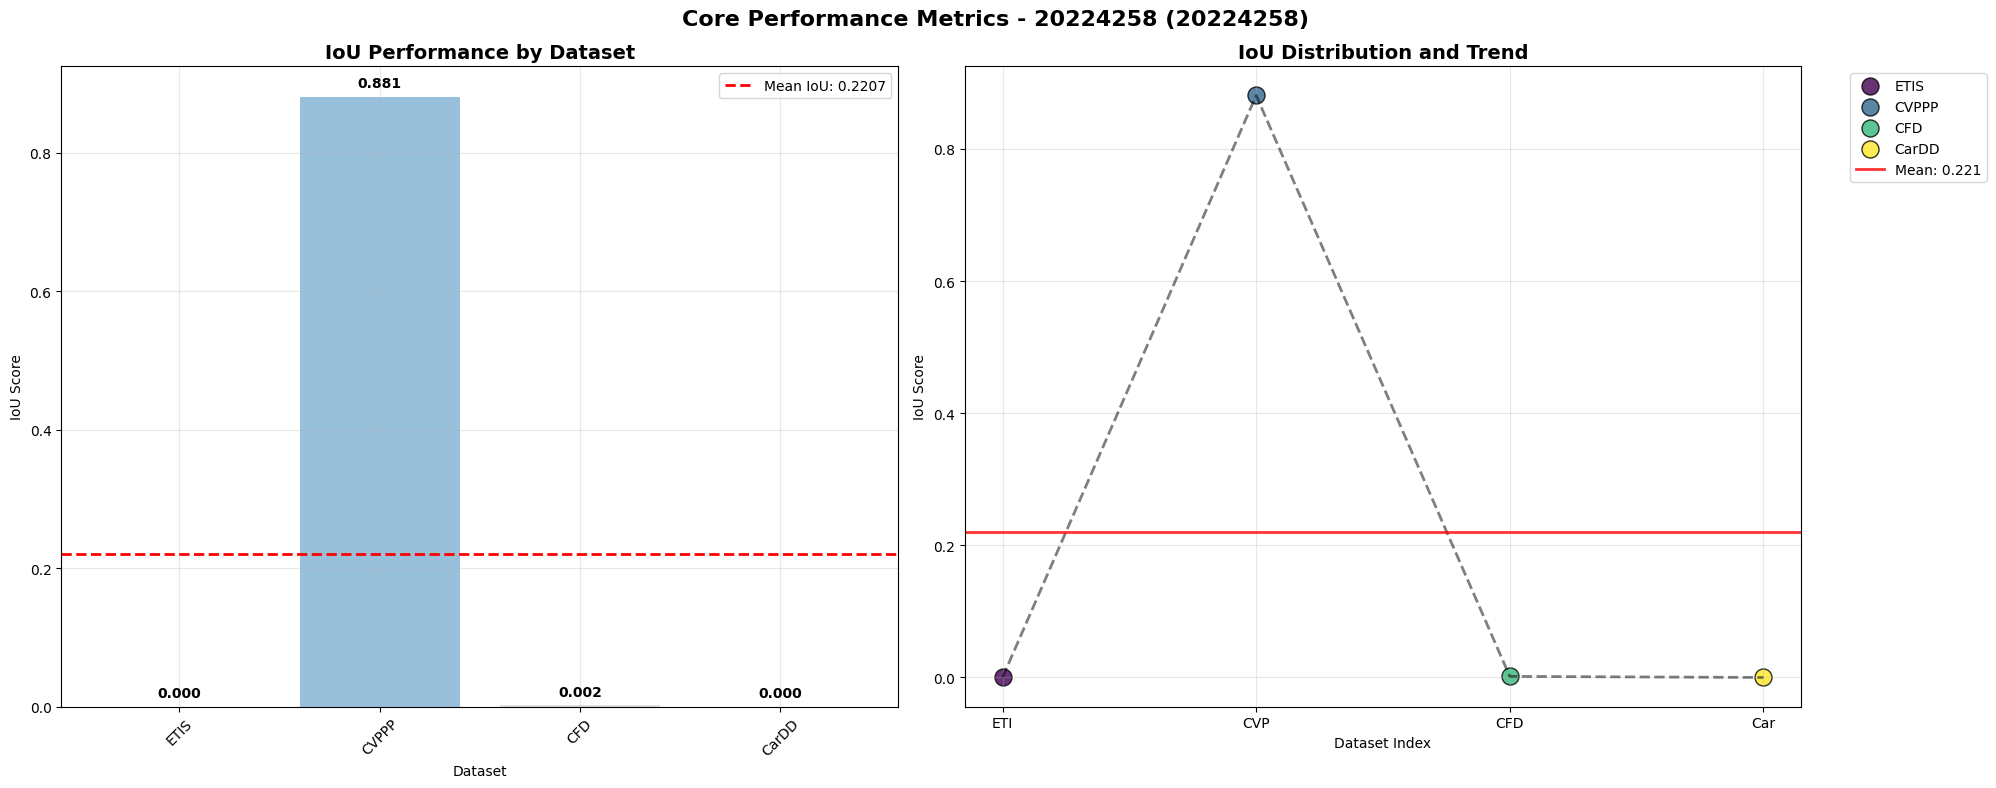

In [9]:
# ==================== 첫 번째 장: 핵심 지표 시각화 ====================
plt.figure(figsize=(20, 8))
plt.suptitle(f'Core Performance Metrics - {student_id} ({model_name})', fontsize=16, fontweight='bold')

# 1-1. 각 데이터셋별 IoU (바 차트)
plt.subplot(1, 2, 1)
colors = plt.cm.Set3(np.linspace(0, 1, len(results_df)))
bars = plt.bar(results_df['Dataset Name'], results_df['IoU'], color=colors, alpha=0.8)
plt.axhline(y=mean_iou, color='red', linestyle='--', linewidth=2, label=f'Mean IoU: {mean_iou:.4f}')
plt.title('IoU Performance by Dataset', fontsize=14, fontweight='bold')
plt.xlabel('Dataset')
plt.ylabel('IoU Score')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)

# 각 바 위에 수치 표시
for bar, value in zip(bars, results_df['IoU']):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
            f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

# 1-2. IoU 분포 (레이더 차트 스타일)
plt.subplot(1, 2, 2)
datasets = results_df['Dataset Name'].tolist()
iou_scores = results_df['IoU'].tolist()

# 색상 맵 생성
colors = plt.cm.viridis(np.linspace(0, 1, len(datasets)))

for i, (dataset, iou, color) in enumerate(zip(datasets, iou_scores, colors)):
    plt.scatter(i, iou, s=150, c=[color], alpha=0.8, label=dataset, edgecolors='black', linewidth=1)

plt.plot(range(len(datasets)), iou_scores, 'k--', alpha=0.5, linewidth=2)
plt.axhline(y=mean_iou, color='red', linestyle='-', alpha=0.8, linewidth=2,
            label=f'Mean: {mean_iou:.3f}')
plt.title('IoU Distribution and Trend', fontsize=14, fontweight='bold')
plt.xlabel('Dataset Index')
plt.ylabel('IoU Score')
plt.xticks(range(len(datasets)), [d[:3] for d in datasets])  # 줄여서 표시
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(output_root+'/'+f'core_performance_{Experiments_Time}.png')
plt.show()

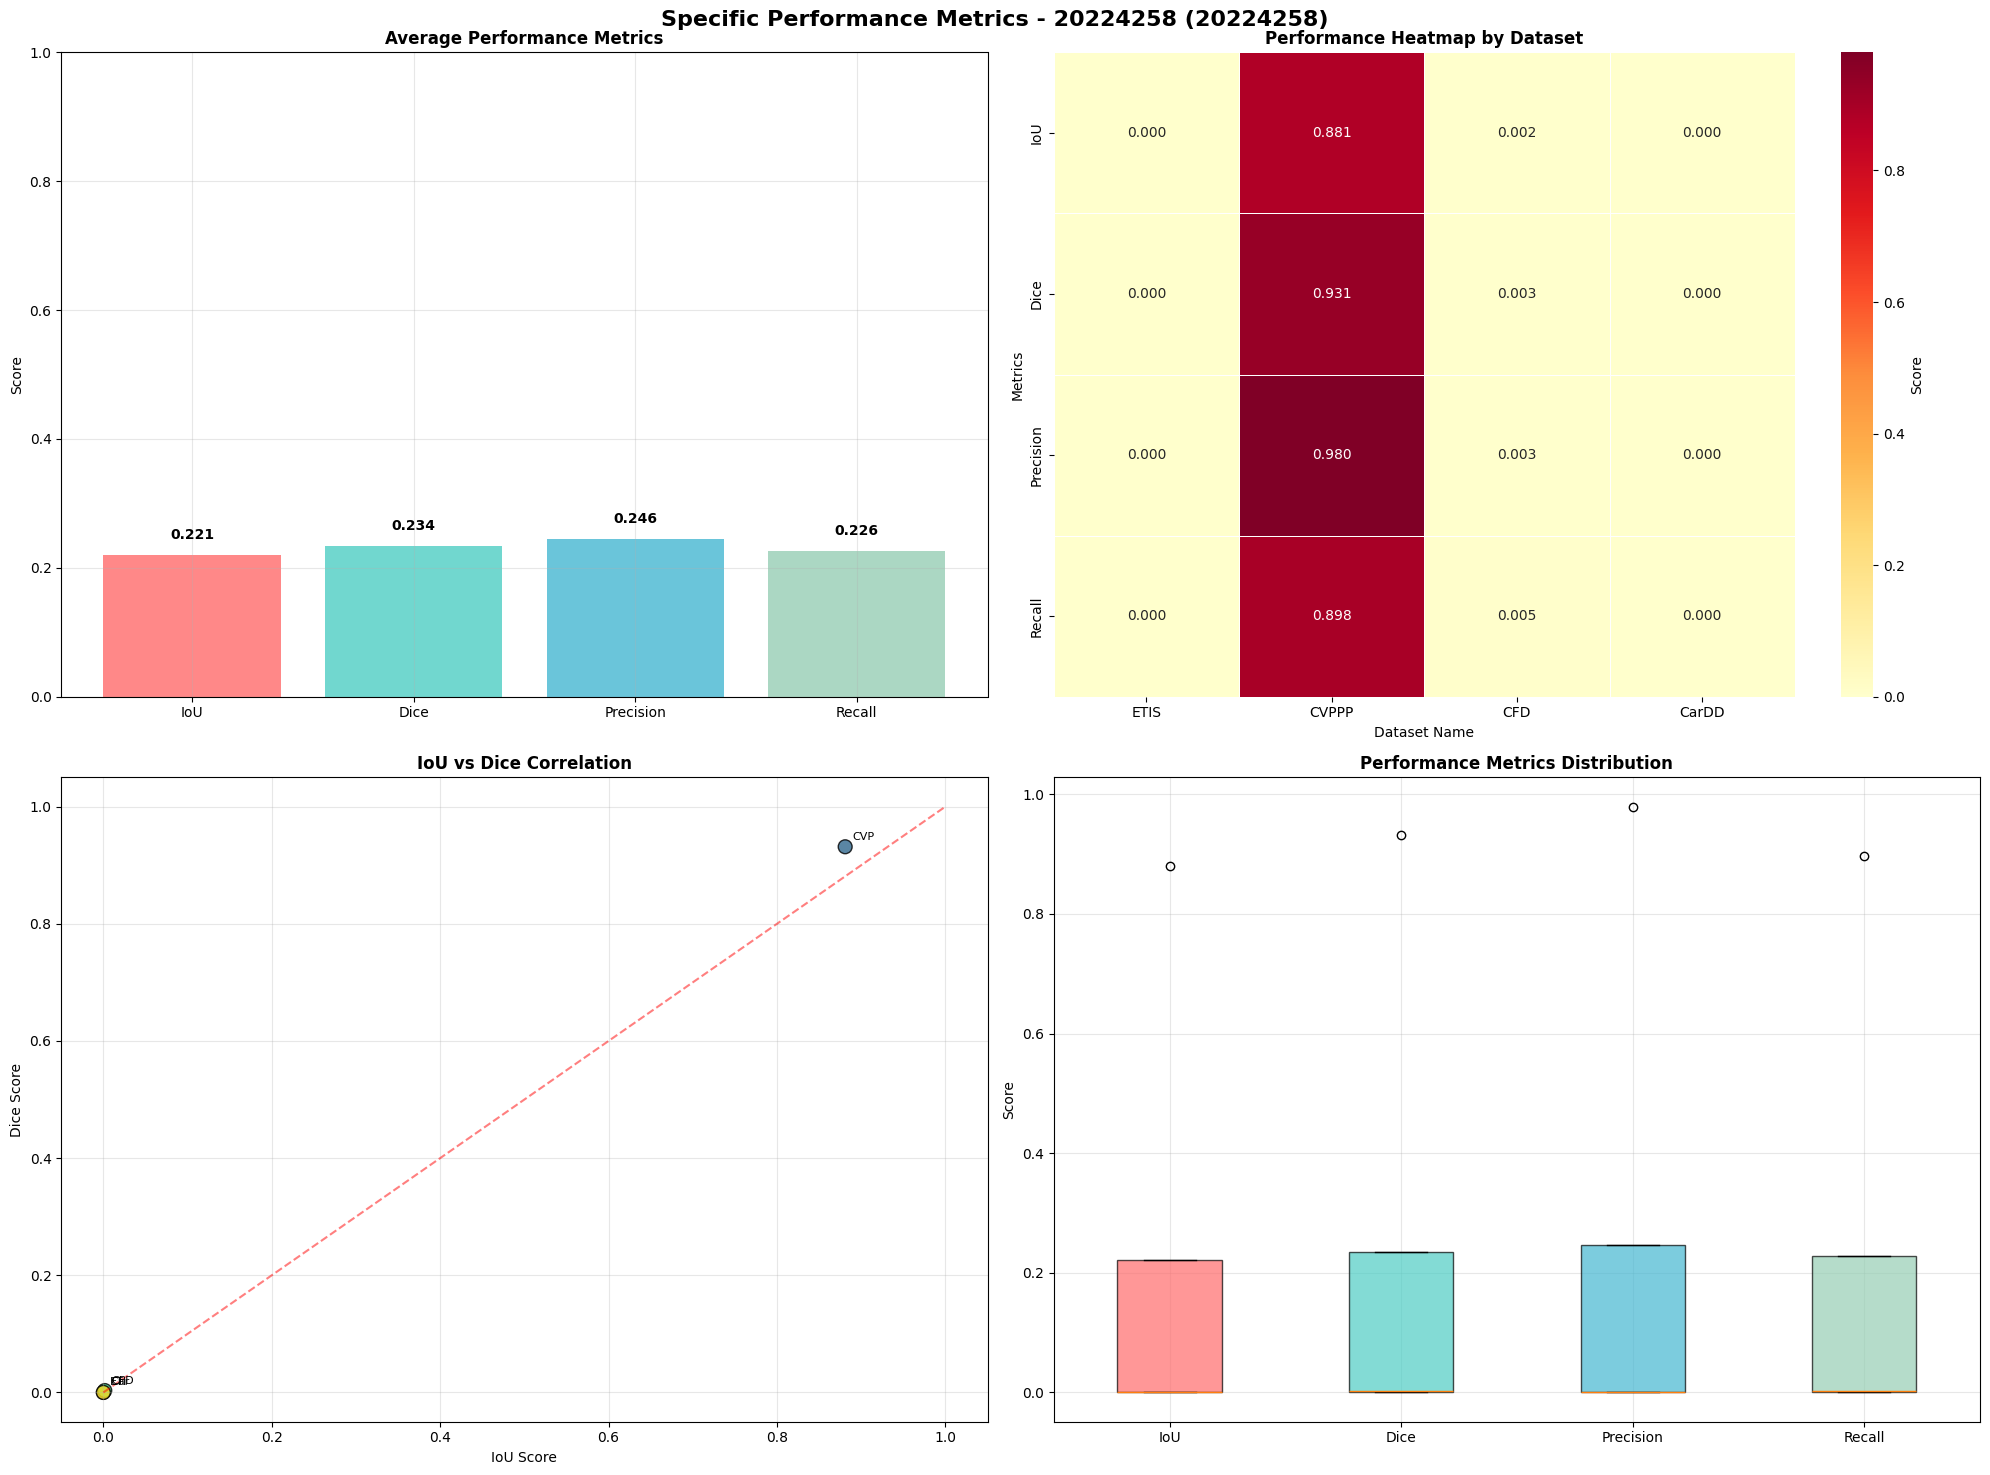

In [10]:
# ==================== 두 번째 장: 상세 분석 ====================
plt.figure(figsize=(20, 15))
plt.suptitle(f'Specific Performance Metrics - {student_id} ({model_name})', fontsize=16, fontweight='bold')

# 2-1. 전체 성능 지표 비교
plt.subplot(2, 2, 1)
metrics = ['IoU', 'Dice', 'Precision', 'Recall']
values = [results_df[metric].mean() for metric in metrics]
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']
bars = plt.bar(metrics, values, color=colors, alpha=0.8)
plt.title('Average Performance Metrics', fontsize=12, fontweight='bold')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.grid(True, alpha=0.3)

# 각 바 위에 수치 표시
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
            f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

# 2-2. 데이터셋별 성능 히트맵
plt.subplot(2, 2, 2)
heatmap_data = results_df[['IoU', 'Dice', 'Precision', 'Recall']].T
heatmap_data.columns = results_df['Dataset Name']

sns.heatmap(heatmap_data, annot=True, cmap='YlOrRd', fmt='.3f', 
            cbar_kws={'label': 'Score'}, linewidths=0.5)
plt.title('Performance Heatmap by Dataset', fontsize=12, fontweight='bold')
plt.ylabel('Metrics')

# 2-3. IoU vs Dice 상관관계
plt.subplot(2, 2, 3)
plt.scatter(results_df['IoU'], results_df['Dice'], c=range(len(results_df)), 
           cmap='viridis', s=100, alpha=0.8, edgecolors='black')
plt.plot([0, 1], [0, 1], 'r--', alpha=0.5)  # 대각선
plt.xlabel('IoU Score')
plt.ylabel('Dice Score')
plt.title('IoU vs Dice Correlation', fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3)

# 각 점에 데이터셋 이름 표시
for i, dataset in enumerate(results_df['Dataset Name']):
    plt.annotate(dataset[:3], (results_df['IoU'].iloc[i], results_df['Dice'].iloc[i]),
                xytext=(5, 5), textcoords='offset points', fontsize=8)

# 2-4. 성능 지표별 분포
plt.subplot(2, 2, 4)
metrics_data = []
metrics_labels = []
for metric in ['IoU', 'Dice', 'Precision', 'Recall']:
    metrics_data.append(results_df[metric].tolist())
    metrics_labels.append(metric)

box_plot = plt.boxplot(metrics_data, labels=metrics_labels, patch_artist=True)
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']
for patch, color in zip(box_plot['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

plt.title('Performance Metrics Distribution', fontsize=12, fontweight='bold')
plt.ylabel('Score')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(output_root+'/'+f'detail_performance_{Experiments_Time}.png')
plt.show()


In [11]:
# === 마지막 셀: 실험 내역 요약 & Markdown 저장 (샘플 이미지, 그래프, Core/Detail CSV 테이블 포함) ===
import glob, importlib.util, torch
from pathlib import Path
from IPython.display import Markdown, display
import pandas as pd

# 1) Performance Metrics
metrics_summary = {
    'Mean IoU': mean_iou,
    'Mean Dice': results_df['Dice'].mean(),
    'Mean Precision': results_df['Precision'].mean(),
    'Mean Recall': results_df['Recall'].mean(),
    'Total Params': total_params
}

# 2) 샘플 이미지 (최대 4개)
sample_images = glob.glob(f"{vis_root}/*/*.png")[:4]

# 3) 분석용 그래프 이미지 (output_root/*.png)
graph_images = glob.glob(f"{output_root}/*.png")

# 4) Core & Detail CSV 경로 자동 탐색
csv_files = glob.glob(f"{output_root}/*.csv")
core_csv_path   = next((p for p in csv_files if 'core'   in Path(p).name.lower()), None)
detail_csv_path = next((p for p in csv_files if 'detail' in Path(p).name.lower()), None)

# 5) CSV 읽기
core_df   = pd.read_csv(core_csv_path)   if core_csv_path   else pd.DataFrame()
detail_df = pd.read_csv(detail_csv_path) if detail_csv_path else pd.DataFrame()

# 6) training_args.py 동적 로드
spec = importlib.util.spec_from_file_location('training_args', 'training_args.py')
training_args = importlib.util.module_from_spec(spec)
spec.loader.exec_module(training_args)

# 7) 더미 모델 생성 후 옵티마이저/스케줄러/손실 함수 인스턴스
class _Dummy(torch.nn.Module):
    def parameters(self): return [torch.nn.Parameter(torch.zeros(1))]
dummy = _Dummy()
opt     = training_args.Make_Optimizer(dummy)
sch     = training_args.Make_LR_Scheduler(opt)

# Binary와 Multiclass 두 경우 모두 생성
loss_fn_binary = training_args.Make_Loss_Function(2)    # Binary case (클래스 수 = 2)
loss_fn_multi  = training_args.Make_Loss_Function(21)   # Multiclass case (VOC 21클래스)

# 8) 하이퍼파라미터 추출
opt_params = {k: v for k,v in opt.defaults.items() if k in ('lr','momentum','weight_decay','betas','eps')}
sch_params = {
    'type':      sch.__class__.__name__,
    'T_max':     getattr(sch, 'T_max', None),
    'warmup':    getattr(sch, 'warmup_iters', None),
    'eta_min':   getattr(sch, 'eta_min', None),
    'power':     getattr(sch, 'power', None),
}
# Binary와 Multiclass loss function 정보 추출
def extract_loss_params(loss_fn, case_name):
    params = {'type': loss_fn.__class__.__name__, 'case': case_name}
    for attr in ('alpha','gamma','weight','ignore_index','mode'):
        if hasattr(loss_fn, attr):
            params[attr] = getattr(loss_fn, attr)
    return params

loss_params_binary = extract_loss_params(loss_fn_binary, 'Binary (2 classes)')
loss_params_multi = extract_loss_params(loss_fn_multi, 'Multiclass (21 classes)')

# 9) Markdown 조립
md_lines = [
    '# 📝 실험 내역 요약',
    '## ▶ Performance Metrics'
]
for k,v in metrics_summary.items():
    if k == 'Total Params':
        md_lines.append(f"- **{k}**: `{v:,}`")  # 쉼표 형식으로 표시
    else:
        md_lines.append(f"- **{k}**: `{v:.4f}`")

# 그래프 이미지
md_lines += ['', '## ▶ 분석용 그래프']
for img in graph_images:
    img_name = Path(img).name
    md_lines.append(f"![{img_name}]({img_name})")

# Core CSV 테이블
if not core_df.empty:
    md_lines += ['', '## ▶ Core Metrics']
    # DataFrame.to_markdown() 로 생성된 텍스트를 한 줄씩 추가
    md_lines += core_df.to_markdown(index=False).split('\n')

# Detail CSV 테이블
if not detail_df.empty:
    md_lines += ['', '## ▶ Detail Metrics']
    md_lines += detail_df.to_markdown(index=False).split('\n')

# Hyperparameters
md_lines += ['', '## ▶ Hyperparameters']
md_lines.append(f"### Optimizer ({opt.__class__.__name__})")
for k,v in opt_params.items():
    md_lines.append(f"- `{k}`: `{v}`")

md_lines.append(f"### Scheduler ({sch_params.pop('type')})")
for k,v in sch_params.items():
    md_lines.append(f"- `{k}`: `{v}`")

# Loss Functions (Binary & Multiclass)
md_lines.append("### Loss Functions")

md_lines.append(f"#### Binary Case ({loss_params_binary.pop('type')})")
for k,v in loss_params_binary.items():
    md_lines.append(f"- `{k}`: `{v}`")

md_lines.append(f"#### Multiclass Case ({loss_params_multi.pop('type')})")
for k,v in loss_params_multi.items():
    md_lines.append(f"- `{k}`: `{v}`")

md_text = '\n'.join(md_lines)

# 10) 화면에 출력
#display(Markdown(md_text))

# 11) Markdown 파일로 저장
output_dir = Path(output_root)
output_dir.mkdir(parents=True, exist_ok=True)
md_path = output_dir / f"experiment_summary_{Experiments_Time}.md"
md_path.write_text(md_text, encoding='utf-8')

print(f"✅ Markdown 요약이 저장되었습니다: {md_path}")


✅ Markdown 요약이 저장되었습니다: output/output_250616_231122/experiment_summary_250616_231122.md
